# RNN VS LSTM VS GRU 

RNN 
- simplest form of sequential model
- suffers from the vanishing gradient problem  - making it difficult to learn long term dependencies

LSTM 
- has 3 gates :forget gate (controls what information to discard), input gate (controls what new information to store), and output gate (controls what information to output).
- better at capturing long-term dependencies than RNN's

GRU 
- simlified version of LSTM with 2 gates: update gate (combines input and forget gates) and reset gate.
- faster than LSTM : as it has fewer parameters than LSTM 

In [3]:
!pip install yfinance

In [19]:
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 1.8/216.1 MB 11.2 MB/s eta 0:00:20
   - -------------------------------------- 5.8/216.1 MB 15.3 MB/s eta 0:00:14
   - -------------------------------------- 8.7/216.1 MB 14.9 MB/s eta 0:00:14
   -- ------------------------------------- 11.5/216.1 MB 14.7 MB/s eta 0:00:14
   -- ------------------------------------- 15.2/216.1 MB 15.4 MB/s eta 0:00:14
   --- ------------------------------------ 19.1/216.1 MB 15.9 MB/s eta 0:00:13
   ---- ----------------------------------- 22.5/216.1 MB 15.8 MB/s eta 0:00:13
   ---- ----------------------------------- 25.2/216.1 MB 15.6 MB/s eta 0:00:13
   ----- ---------------------------------- 28.6/216.1 MB 15.8 MB/s eta 0:00:12
   ------ --------------------------------- 32.8/216.1 MB 16.1 MB/s eta 0:00:12
   ------ --------------------------------- 36.4/216.1 MB 16.2 MB/s et

# Looking at an RNN model 

(also preparing data for LSTM , RNN for later on ) 

## 1. Install and import packages 

In [21]:
import yfinance as yf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
import torch.nn as nn
import torch



## 2. Download Stock Data

In [53]:
# Download historical stock data (e.g., AAPL)
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")

# Just use the 'Close' price for modeling
data = data[['Close']].dropna()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1904\3066661078.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


## 3. Normalize the data 

RNNs train better on scaled data 

In [54]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

## 4. Create Sequences for RNN input + train-test split + convert to tensors 

RNNs require sequential data, so we will split into:
    - X : Sequence of past prices (e.g 60 days)
    - y: next day price 

RNNs peform better on short sequences but this isn't the same as a small time frame 

In [55]:
# Create sequences for RNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5  # you can adjust this
X, y = create_sequences(scaled_data, seq_length)

#train test split 
# Assume X and y are NumPy arrays
train_size = int(len(X) * 0.8)  # 80% for training

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


## 5. Build a simple RNN in Pytorch 


In [56]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # use last time step
        out = self.fc(out)
        return out

## 6. Train the RNN model 

In [57]:
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.0799
Epoch 2/20, Loss: 0.0727
Epoch 3/20, Loss: 0.0660
Epoch 4/20, Loss: 0.0599
Epoch 5/20, Loss: 0.0543
Epoch 6/20, Loss: 0.0492
Epoch 7/20, Loss: 0.0447
Epoch 8/20, Loss: 0.0408
Epoch 9/20, Loss: 0.0374
Epoch 10/20, Loss: 0.0346
Epoch 11/20, Loss: 0.0323
Epoch 12/20, Loss: 0.0306
Epoch 13/20, Loss: 0.0294
Epoch 14/20, Loss: 0.0287
Epoch 15/20, Loss: 0.0283
Epoch 16/20, Loss: 0.0283
Epoch 17/20, Loss: 0.0285
Epoch 18/20, Loss: 0.0289
Epoch 19/20, Loss: 0.0293
Epoch 20/20, Loss: 0.0297


## 7. Make Predictions 


In [58]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)

print(f"\nTest MSE Loss: {test_loss.item():.4f}")


Test MSE Loss: 0.0358


## 8. Evaluation metric 

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert predictions and targets to NumPy arrays
predicted_test = test_predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Ensure they are 2D: (n_samples, 1)
predicted_test = predicted_test.reshape(-1, 1)
y_test_np = y_test_np.reshape(-1, 1)

# Inverse transform if you want real scale prices
predicted_test_prices = scaler.inverse_transform(predicted_test)
y_test_prices = scaler.inverse_transform(y_test_np)

# MAE and RMSE
mae = mean_absolute_error(y_test_prices, predicted_test_prices)
rmse = np.sqrt(mean_squared_error(y_test_prices, predicted_test_prices))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 32.4204
Test RMSE: 38.6235


## 9. Plot the results 


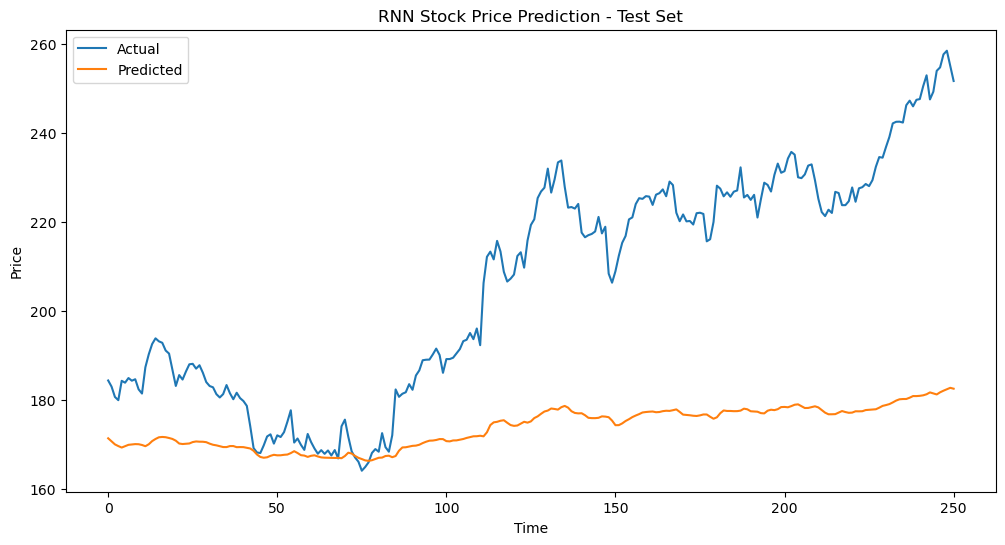

In [61]:

plt.figure(figsize=(12, 6))
plt.plot(y_test_prices, label='Actual')
plt.plot(predicted_test_prices, label='Predicted')
plt.legend()
plt.title('RNN Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Looking at an LSTM model 

## 1. Define LSTM model 

In [143]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)        # out shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]          # take last time step output
        out = self.fc(out)           # output shape: (batch, output_size)
        return out

## 2. modifying sequence length + creating tensors

In [144]:
seq_length = 20  # ideal sequence length for LSTM is 20-60 for stocks 
X, y = create_sequences(scaled_data, seq_length)

#train test split 
# Assume X and y are NumPy arrays
train_size = int(len(X) * 0.8)  # 80% for training

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## 2. Initialize model, loss , optimizer

In [145]:
input_size = X_train.shape[2]   # number of features
hidden_size = 64                # you can tune this
num_layers = 2                 # tune this too
output_size = 1                # predicting next value

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 3. Training loop 

In [146]:
num_epochs = 75 # or more

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/75], Loss: 0.0243
Epoch [20/75], Loss: 0.0234
Epoch [30/75], Loss: 0.0229
Epoch [40/75], Loss: 0.0204
Epoch [50/75], Loss: 0.0155
Epoch [60/75], Loss: 0.0047
Epoch [70/75], Loss: 0.0027


## 4. Evaluation on test data 

In [147]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_loss = criterion(test_preds, y_test_tensor)
    print(f"Test MSE Loss: {test_loss.item():.4f}")

Test MSE Loss: 0.0015


## 5. Inverse scaling and metrics 

In [148]:
# Convert to numpy
test_preds_np = test_preds.numpy()
y_test_np = y_test_tensor.numpy()

# Inverse transform (scaler =  MinMaxScaler)
test_preds_prices = scaler.inverse_transform(test_preds_np) # we scaled the data originally so to go back to original stock price we inverse transform
y_test_prices = scaler.inverse_transform(y_test_np)

mae = mean_absolute_error(y_test_prices, test_preds_prices)
rmse = np.sqrt(mean_squared_error(y_test_prices, test_preds_prices)) # simply the sqrt of mae 

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 6.0704
Test RMSE: 7.8894


## 6. Plotting 

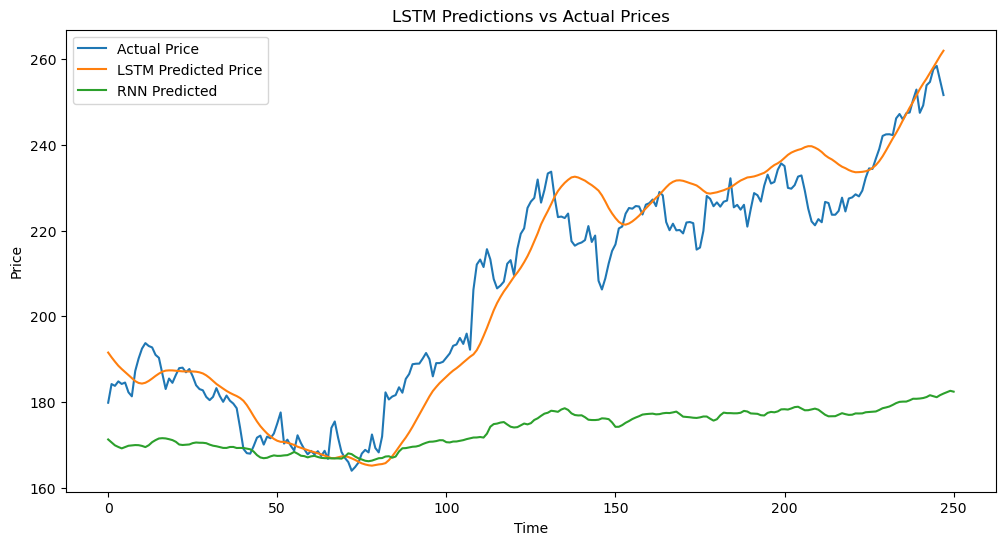

In [149]:
plt.figure(figsize=(12,6))
plt.plot(y_test_prices, label='Actual Price')
plt.plot(test_preds_prices, label='LSTM Predicted Price')
plt.plot(predicted_test_prices, label='RNN Predicted')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Conclusion

As you can see the LSTM peforms much better than the RNN has it can capture more temporal dependancies. 
for the LSTM model : 

    - Test MSE Loss: 0.0015
    - Test MAE: 6.0704
    - Test RMSE: 7.8894

Whereas for the RNN model: 

    - Test MAE: 32.4204
    - Test RMSE: 38.6235

# Looking at a GRU model 

 

Gru is less computationally expensive than an LSTM 

## 1. Defining Gru model 

In [150]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1, dropout=0):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        
        out, _ = self.gru(x, h0)  # out shape: (batch_size, seq_len, hidden_size)

        # Take output from last time step
        out = out[:, -1, :]  # shape: (batch_size, hidden_size)
        out = self.fc(out)   # shape: (batch_size, output_size)
        return out

## 2. Modifying sequence length + creating tensors 

In [151]:
seq_length = 20  # ideal sequence length for LSTM is 20-60 for stocks 
X, y = create_sequences(scaled_data, seq_length)

#train test split 
# Assume X and y are NumPy arrays
train_size = int(len(X) * 0.8)  # 80% for training

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## 2. Intialising model, loss and optimiser 

In [152]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1  # predicting next value

model_GRU = GRUModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.001)

## 3. Training loop 

In [153]:
num_epochs = 75 # or more

for epoch in range(num_epochs):
    model_GRU.train()
    optimizer.zero_grad()

    outputs = model_GRU(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/75], Loss: 0.0312
Epoch [20/75], Loss: 0.0207
Epoch [30/75], Loss: 0.0168
Epoch [40/75], Loss: 0.0126
Epoch [50/75], Loss: 0.0060
Epoch [60/75], Loss: 0.0010
Epoch [70/75], Loss: 0.0011


## 4. Evaluation on test data

In [154]:
model.eval()
with torch.no_grad():
    test_preds_GRU = model_GRU(X_test_tensor)
    test_loss_GRU = criterion(test_preds, y_test_tensor)
    print(f"Test MSE Loss: {test_loss.item():.4f}")

Test MSE Loss: 0.0015


## 5. Inverse Scaling and Metrics 

In [155]:
# Convert to numpy
test_preds_np = test_preds_GRU.numpy()
y_test_np = y_test_tensor.numpy()

# Inverse transform (assuming scaler is your scaler instance, e.g. MinMaxScaler)
test_preds_prices_GRU = scaler.inverse_transform(test_preds_np)
y_test_prices = scaler.inverse_transform(y_test_np)

mae = mean_absolute_error(y_test_prices, test_preds_prices_GRU)
rmse = np.sqrt(mean_squared_error(y_test_prices, test_preds_prices_GRU))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 7.4621
Test RMSE: 9.5449


## 6. Plotting

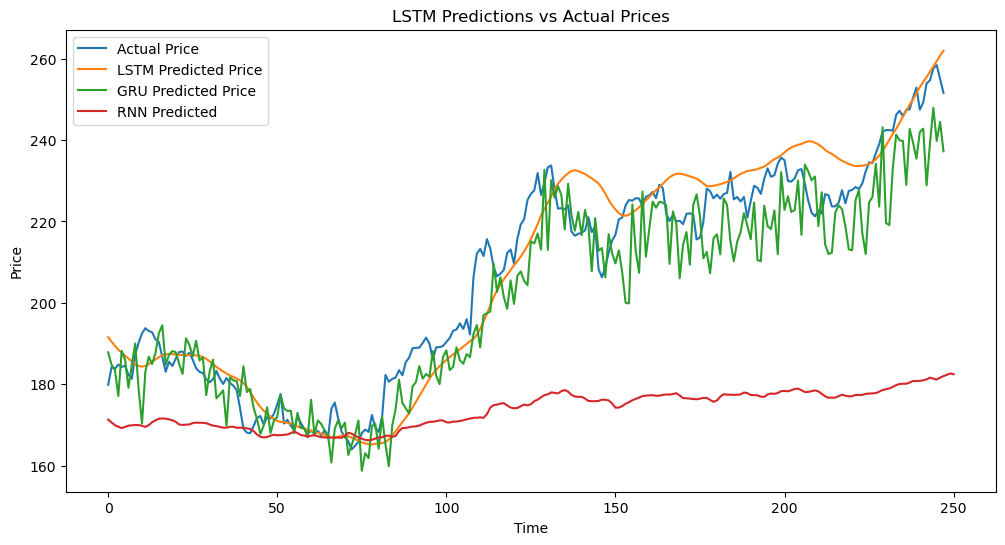

In [156]:
plt.figure(figsize=(12,6))
plt.plot(y_test_prices, label='Actual Price')
plt.plot(test_preds_prices, label='LSTM Predicted Price')
plt.plot(test_preds_prices_GRU, label='GRU Predicted Price')
plt.plot(predicted_test_prices, label='RNN Predicted')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Conclusion 

Here the GRU is very close to the LSTM model but doesn't outpeform it  

For hte GRU model we have: 

    - Test MSE Loss: 0.0015
    - Test MAE: 7.4621
    - Test RMSE: 9.5449

Whereas for hte LSTM model we had: 

    - Test MSE Loss: 0.0015
    - Test MAE: 6.0704
    - Test RMSE: 7.8894